<a href="https://colab.research.google.com/github/HSabbar/Detection-Fraude/blob/master/Detection_de_Fraude_v31_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Détection de fraude avec Keras - Colab Notebooks



In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams

In [0]:
%matplotlib inline

LABELS = ["Normal", "Fraude"]
sns.set(style='whitegrid',palette='muted',font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [158]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/dataset/creditcard_final.csv")
df_tmp = df
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#Dataset 
Partie 1 : [*Obtenu sur Kaggle*](https://www.kaggle.com/mlg-ulb/creditcardfraud)

Partie 2 : Élargir le jeu de données obtenu sur kaggle, à partir des projets qui traite les données des transactions bancaires. 

L'ensemble des données contiennent des transactions effectuées par carte de crédit. Cet ensemble de données présente les transactions, où nous avons 556 (492 avant l'élargirment de dataset) fraudes sur 287 827 transactions. Le jeu de donnée est très déséquilibré, la classe positive (fraudes) représente 0,1928% de toutes les transactions.

Il ne contient que des variables d'entrée numériques qui sont le résultat d'une transformation PCA. En raison de confidentialité, nous ne connaissons pas les fonctionnalités d'origine des informations sur les données. Les fonctionnalités V1, V2,… V28 sont les principaux composants obtenus avec PCA, les seules fonctionnalités qui n'ont pas été transformées avec PCA sont 'Time' et 'Amount'. La fonction «Time» contient les secondes écoulées entre chaque transaction et la première transaction de l'ensemble de données.

In [0]:
import matplotlib.pyplot as plt



1.    Le jeu de donnée est très déséquilibré, la classe positive (fraudes) représente 0,1928% de toutes les transactions.
2.   La classe de normal (non Fraude) représente 99,81%



In [160]:
Fraude = df[df.Class == 1]
normal = df[df.Class == 0]

print(len(Fraude))
print(len(normal))

print(df['Class'].value_counts())

556
287827
0    287827
1       556
Name: Class, dtype: int64


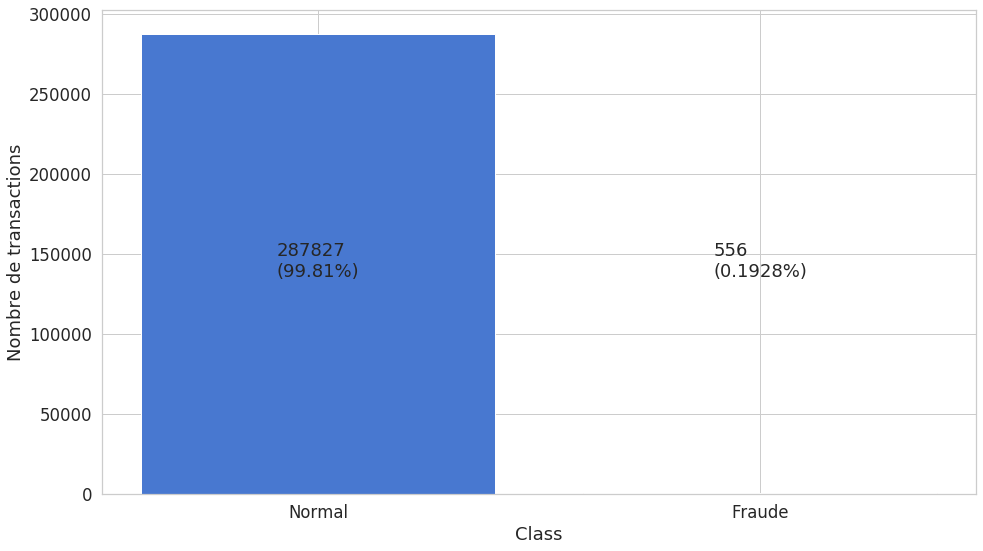

In [161]:
plt.bar(LABELS, df['Class'].value_counts(), color=['b','r'])
plt.xlabel('Class')
plt.ylabel('Nombre de transactions')
plt.annotate('{}\n({:.4}%)'.format(df['Class'].value_counts()[0], df['Class'].value_counts()[0]/df['Class'].count()*100),
             (0.20, 0.45), xycoords='axes fraction')
plt.annotate('{}\n({:.4}%)'.format(df['Class'].value_counts()[1], df['Class'].value_counts()[1]/df['Class'].count()*100),
             (0.70, 0.45), xycoords='axes fraction')
plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/dataset-plt.png')

#Normaliser et mettre à l'échelle les données : 
Le temps et la montant ont une importance très différentes, ce qui entraînera probablement un déséquilibre des données. Il est donc courant de redimensionner les données à des importance similaires. 

La plupart des données (autres que le «temps» et la montant) résultent du produit d'une analyse PCA. L'PCA effectuée sur l'ensemble de données l'a transformé en une forme standard-normale. Je ferai de même pour les colonnes «temps» et «montant» 

In [0]:
# pre- processing
from sklearn.preprocessing import StandardScaler

In [0]:
try:
  for i in range(0, len(df.columns)):
    df.iloc[:,i] = pd.to_numeric(df.iloc[:,i], errors='ignore')
  # df = pd.to_numeric(df[0:], downcast='float', errors='coerce')

except ValueError as e:
        # print ("error",e)
        pass


In [164]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
df['Time'] = StandardScaler().fit_transform((df['Time'].values).reshape(-1,1))
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))

In [166]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996359,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.248219,0
1,-1.996359,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.341724,0
2,-1.996338,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.167845,0
3,-1.996338,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.143344,0
4,-1.996317,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.071505,0


*Extraire des données de validation de modele que nous ne passons pas à l'apprentissage* 

In [167]:
Fraude = df[df.Class == 1]
normal = df[df.Class == 0]
print(Fraude.shape)
Fraude.head()

(556, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
561,-1.987822,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.352524,1
643,-1.986434,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.771479,1
5006,-1.902541,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,0.610826,1
6198,-1.849472,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,-0.115632,1
6419,-1.838265,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,-0.348509,1


In [0]:

X_val_model_fraude =  df.iloc[[561, 643, 5006, 6198]] 
X_val_model_normal =  df.iloc[[0, 2,3, 4]] 

len_df_avant_data_validation = len(df)
# print(len_df_avant_data_validation)

In [0]:
df = df.drop(df.index[[561, 643, 5006, 6198]])
df = df.drop(df.index[[0, 2,3, 4]])

In [170]:
X_val_model_fraude = X_val_model_fraude.iloc[:, df.columns != 'Class']
X_val_model_normal = X_val_model_normal.iloc[:, df.columns != 'Class']

X_val_model_fraude = np.array(X_val_model_fraude)
X_val_model_normal = np.array(X_val_model_normal)


frauds = df[df.Class == 1]
print(frauds.shape)

# len_df_apers_enlver_data_validation = len(df)


(552, 31)


In [171]:
X = df.iloc[:, df.columns != 'Class']
y = df.iloc[:, df.columns == 'Class']
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
1,-1.996359,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.341724
5,-1.996317,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.337789
6,-1.996274,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.332489
7,-1.996211,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,-0.188707
8,-1.996211,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.021686


In [172]:
y.head()

,Class
1,0
5,0
6,0
7,0
8,0


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [175]:
print(X_train.shape)
print(X_train.shape)

(201862, 30)
(201862, 30)


In [0]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_trian = np.array(y_train)
y_test = np.array(y_test)

In [0]:
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.layers import Dropout

In [178]:
model =  Sequential([
    Dense(units=16, input_dim = 30,activation = 'relu'),
    Dense(units = 24, activation = 'relu'),
    Dropout(0.5),
    Dense( 20, activation = 'relu'),
    Dense(24, activation = 'relu'),
    Dense(1, activation = 'sigmoid'),
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 16)                496       
_________________________________________________________________
dense_12 (Dense)             (None, 24)                408       
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)                500       
_________________________________________________________________
dense_14 (Dense)             (None, 24)                504       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 25        
Total params: 1,933
Trainable params: 1,933
Non-trainable params: 0
____________________________________________________

In [0]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(X_train, y_trian, batch_size =15, epochs = 5)




Epoch 1/5





201862/201862 [==============================] - 84s 418us/step - loss: 0.0084 - acc: 0.9989
Epoch 2/5
201862/201862 [==============================] - 75s 370us/step - loss: 0.0045 - acc: 0.9992
Epoch 3/5
201862/201862 [==============================] - 74s 366us/step - loss: 0.0039 - acc: 0.9993
Epoch 4/5
201862/201862 [==============================] - 72s 359us/step - loss: 0.0039 - acc: 0.9993
Epoch 5/5
201862/201862 [==============================] - 72s 357us/step - loss: 0.0036 - acc: 0.9994


*Evaluer le modèle formé, Sa sortie est la précision et la perte*

In [0]:
score = model.evaluate(X_test, y_test)
print(score)

86513/86513 [==============================] - 4s 52us/step
[0.0026681900400272406, 0.9994798469594165]


**La prédiction :**

In [0]:
def prediction(modell, y, str):
  ynew = modell.predict(y)
  for i in range(len(y)) :
    if str == "fraude": 
      if ynew[i].round() != 0:
        print("X ; prediction = %s " % ( ynew[i].round()))
      else:
        print("X ; prediction = %s (error) =  %s " % ( ynew[i].round(), ynew[i]))
    else : 
      print("X ; prediction = %s " % ( ynew[i].round()))


**Tester de model sur la data fraude**


*   0 : noraml 
*   1 : fraude 



In [0]:
prediction(model, X_val_model_fraude, str="fraude")

X ; prediction = [1.] 
X ; prediction = [0.] (error) =  [0.00383201] 
X ; prediction = [1.] 
X ; prediction = [1.] 


**Tester de model sur la data noraml**

In [0]:
prediction(model, X_val_model_normal, str="normal")

X ; prediction = [0.] 
X ; prediction = [0.] 
X ; prediction = [0.] 
X ; prediction = [0.] 


**On remarque que la détection de fraude de ce model est de 4/5 assze fiable**

*sachant que le model n'a jamais vu ses données*



In [0]:
model.save_weights("/content/gdrive/My Drive/Colab Notebooks/model.h5")

In [0]:
!ls "/content/gdrive/My Drive/Colab Notebooks"

 CCF.ipynb			       model_autoencoder__.h5
'Copie de Detection de Fraude.ipynb'   model.h5
 dataset			       nour
'Detection de Fraude.ipynb'	       Untitled0.ipynb
 detection_fraude.ipynb


In [0]:
model.load_weights("/content/gdrive/My Drive/Colab Notebooks/model.h5")
 
# Évaluer le modèle, chargé sur les données de test ...
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = model.evaluate(X, y)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


acc: 99.96%


## **Autoencoders**

Les encodeurs automatiques peuvent sembler assez bizarres au premier abord. Le travail de ces modèles est de prédire l'entrée, étant donné cette même entrée. Déroutant? C'était définitivement pour moi, la première fois que je l'ai entendu.

Plus précisément, examinons les réseaux de neurones à encodeur automatique. Cet encodeur automatique essaie d'apprendre à approximer la fonction d'identité suivante:

$$\textstyle f_{W,b}(x) \approx x$$
Tout en essayant de faire cela peut sembler trivial au début, il est important de noter que nous voulons apprendre une représentation compressée des données, donc trouver la structure. Cela peut être fait en limitant le nombre d'unités cachées dans le modèle. Ce type d'auto-encodeurs est considéré comme incomplet.

Voici une représentation visuelle de ce qu'un encodeur automatique pourrait apprendre:


**Erreur de reconstruction**

Nous optimisons les paramètres de notre modèle Autoencoder de telle sorte qu'un type spécial d'erreur - erreur de reconstruction est minimisé. En pratique, l'erreur quadratique traditionnelle est souvent utilisée:

$$\textstyle L(x,x') = ||\, x - x'||^2$$


In [179]:
df2 = df_tmp
df2.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996359,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.248219,0
1,-1.996359,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.341724,0
2,-1.996338,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.167845,0
3,-1.996338,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.143344,0
4,-1.996317,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.071505,0


In [180]:
df2["Time"] = df2["Time"].apply(lambda x : x / 3600 % 24)
df2.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,23.999445,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.248219,0
1,23.999445,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.341724,0
2,23.999445,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.167845,0
3,23.999445,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.143344,0
4,23.999445,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.071505,0


In [181]:
#Scaling time et amount ...
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df2['scaled_amount'] = rob_scaler.fit_transform(df2['Amount'].values.reshape(-1,1))
df2['scaled_time'] = rob_scaler.fit_transform(df2['Time'].values.reshape(-1,1))

df2.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df2['scaled_amount']
scaled_time = df2['scaled_time']

df2.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df2.insert(0, 'scaled_amount', scaled_amount)
df2.insert(1, 'scaled_time', scaled_time)

print(len(df2))
df2.head()

288383


,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.809423,-0.000003,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269383,-0.000003,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,5.049943,-0.000003,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.439870,-0.000003,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.682796,-0.000003,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [182]:
#Prendre uniquement les cas non frauduleux...

non_fraud = df2[df2.Class == 0].sample(1000)
fraud = df2[df2.Class == 1]

print("Shape de non-fraude dataset est {}".format(non_fraud.shape))
print("Shape de fraude dataset est {}".format(fraud.shape))

Shape de non-fraude dataset est (1000, 31)
Shape de fraude dataset est (556, 31)


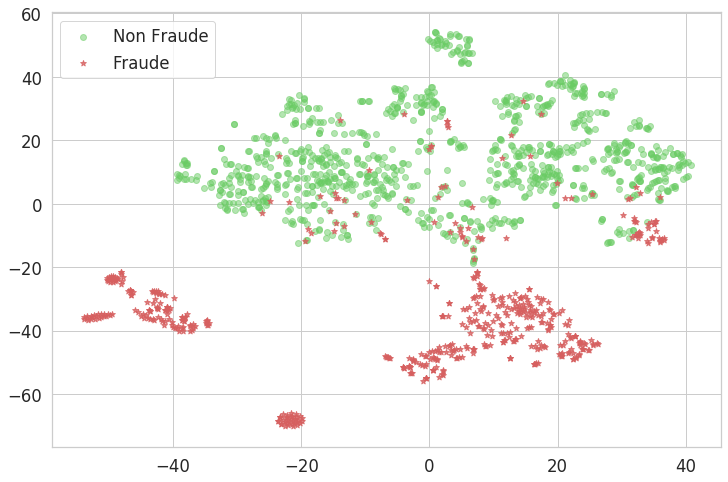

In [183]:
from sklearn.manifold import TSNE

def tsne_plot(x1, y1):
    tsne = TSNE(n_components=2,perplexity = 30, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.5, label='Non Fraude')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='*', color='r', linewidth='1', alpha=0.8, label='Fraude')

    plt.legend(loc='best')
    plt.show()
    
df_tsne = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)    
X = df_tsne.drop(['Class'], axis = 1).values
Y = df_tsne["Class"].values
    
tsne_plot(X, Y)

In [0]:
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard
import tensorflow as tf

In [0]:
# input layer
input_layer = tf.keras.layers.Input(shape=(X.shape[1],))

# encoding 
encoded = tf.keras.layers.Dense(100, activation='tanh', activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_layer)
encoded = tf.keras.layers.Dense(50, activation='relu')(encoded)

# decoding 
decoded = tf.keras.layers.Dense(50, activation='tanh')(encoded)
decoded = tf.keras.layers.Dense(100, activation='tanh')(decoded)

# output layer
output_layer = tf.keras.layers.Dense(X.shape[1], activation='relu')(decoded)

In [186]:
autoencoder = tf.keras.Model(input_layer,output_layer)
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])


autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_13 (Dense)             (None, 100)               5100      
_________________________________________________________________
dense_14 (Dense)             (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_______________________________________________________

In [0]:
x = df2.drop(["Class"], axis=1)
y = df2["Class"].values

x_norm, x_fraud = x[y == 0], x[y == 1]

In [237]:
history = autoencoder.fit(x, x, 
                batch_size = 512, epochs = 50, 
                shuffle = True, validation_split = 0.30).history

Train on 201868 samples, validate on 86515 samples
Epoch 1/50
201868/201868 [==============================] - 2s 8us/sample - loss: 0.6182 - acc: 0.9463 - val_loss: 0.6610 - val_acc: 0.9552
Epoch 2/50
201868/201868 [==============================] - 2s 8us/sample - loss: 0.6338 - acc: 0.9157 - val_loss: 0.6455 - val_acc: 0.9645
Epoch 3/50
201868/201868 [==============================] - 2s 7us/sample - loss: 0.6129 - acc: 0.9571 - val_loss: 0.6613 - val_acc: 0.9408
Epoch 4/50
201868/201868 [==============================] - 2s 8us/sample - loss: 0.6146 - acc: 0.9505 - val_loss: 0.6515 - val_acc: 0.9601
Epoch 5/50
201868/201868 [==============================] - 2s 8us/sample - loss: 0.6132 - acc: 0.9508 - val_loss: 0.6495 - val_acc: 0.9695
Epoch 6/50
201868/201868 [==============================] - 2s 8us/sample - loss: 0.6191 - acc: 0.9404 - val_loss: 0.6671 - val_acc: 0.9269
Epoch 7/50
201868/201868 [==============================] - 2s 8us/sample - loss: 0.6198 - acc: 0.9403 - val_

In [0]:
autoencoder.save_weights("/content/gdrive/My Drive/Colab Notebooks/model_autoencoder__.h5")

In [0]:
predictions = autoencoder.predict(X_test)

In [0]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test.ravel()})

In [0]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.legend()
    plt.show()

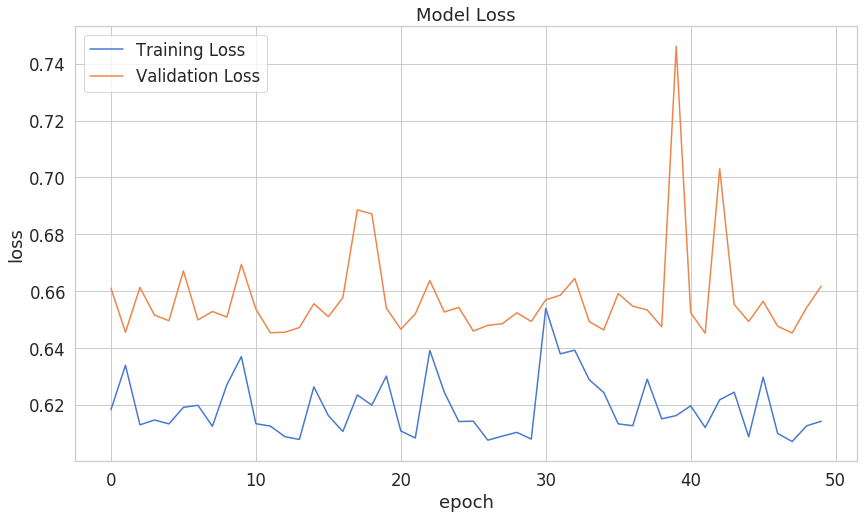

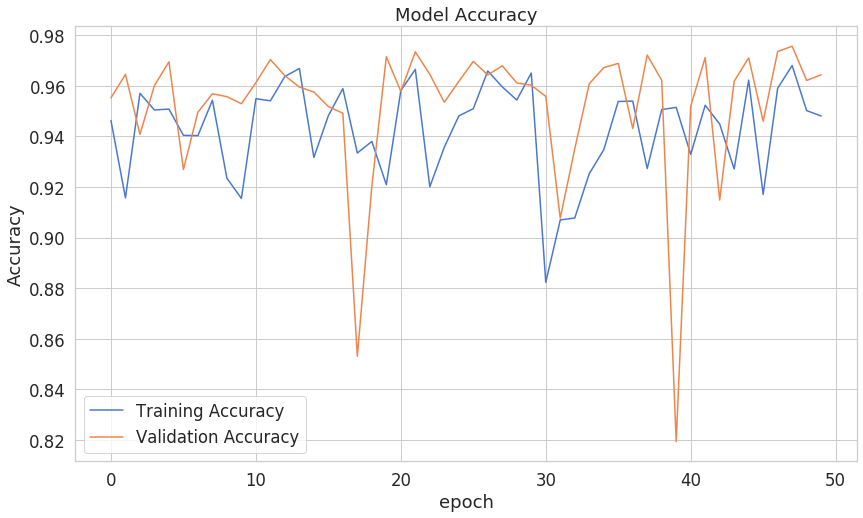

In [241]:
plot_metrics(history)

In [0]:
hidden_representation = tf.keras.models.Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [0]:
##la prédiction
norm_hid_rep = hidden_representation.predict(x_norm[:4000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

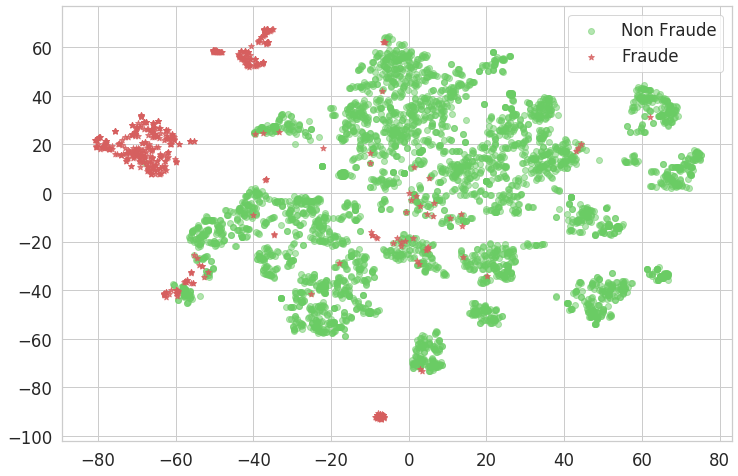

In [244]:
##Visualisation

rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y)

In [0]:
 from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

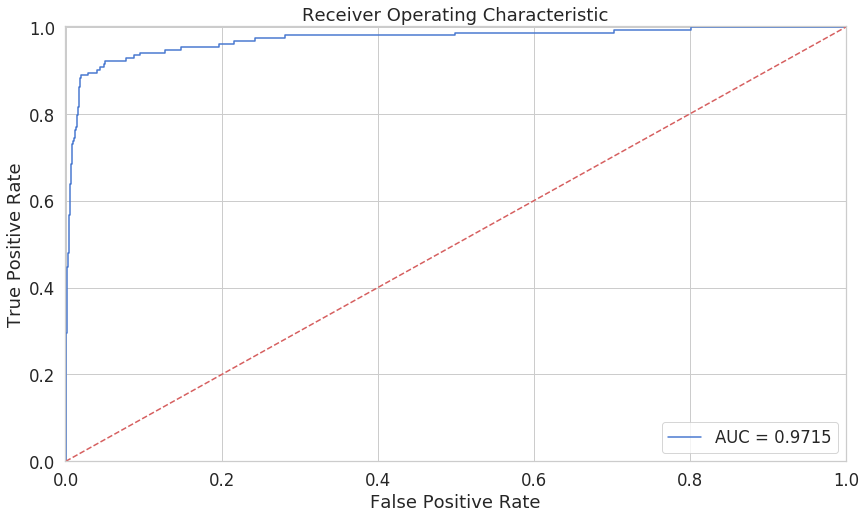

In [246]:

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [0]:
#Logistic Regression 
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

In [0]:
#Random Forest 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 500,max_depth = 5).fit(train_x,train_y)

pred_rf = rf.predict(val_x)

In [0]:
# SVM
sv = SVC(kernel = 'rbf').fit(train_x,train_y)

pred_sv = sv.predict(val_x)

In [251]:
from sklearn.model_selection import GridSearchCV
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
degrees = [2,3]
param_grid = {'C': Cs, 'gamma' : gammas,'degree':degrees}
grid_svc = GridSearchCV(estimator = sv,
                        param_grid = param_grid,
                       scoring = 'recall',
                       cv = 3,
                       verbose = 1)
grid_svc.fit(train_x,train_y)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   16.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'degree': [2, 3],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=1)

In [0]:
# SVC 
sv_op = SVC(C = 10,degree = 2,kernel = 'rbf',gamma = 0.1).fit(train_x,train_y)
pred_sv_op = sv_op.predict(val_x)

In [0]:
# Randomforest 
rf_op = RandomForestClassifier(n_estimators = 500,max_depth = 5,criterion = 'gini',max_features = 'sqrt').fit(train_x,train_y)
pred_rf_op = rf_op.predict(val_x)

In [0]:
from sklearn.ensemble import VotingClassifier
classifiers = [('Logistic Regression',clf),
              ('SVM',sv_op),
              ('Random Forest',rf_op)]

vc = VotingClassifier(estimators = classifiers,
                     voting = 'hard').fit(train_x,train_y)
pred_vc = vc.predict(val_x)

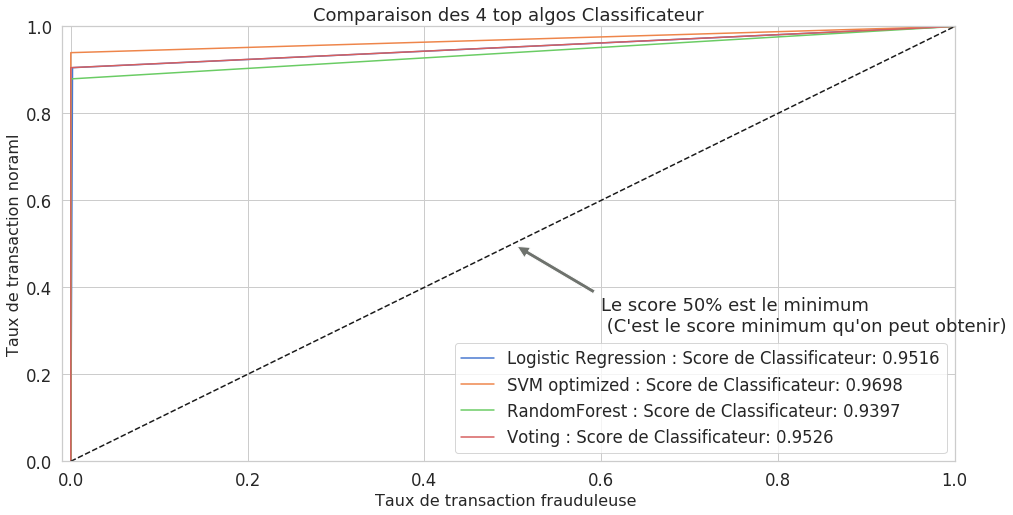

In [255]:
from sklearn.metrics import roc_curve,roc_auc_score
#logistic regression
log_fpr, log_tpr, log_thresold = roc_curve(val_y, pred_y)
#optimized svc
svc_fpr, svc_tpr, scv_threshold = roc_curve(val_y, pred_sv_op)
#optimized rf
rf_fpr, rf_tpr, rf_threshold = roc_curve(val_y,pred_rf_op)
#voting classifier
vote_fpr, vote_tpr, vote_threshold = roc_curve(val_y, pred_vc)


def graph_roc_curve_multiple(log_fpr, log_tpr, svc_fpr, svc_tpr, rf_fpr,rf_tpr,vote_fpr, vote_tpr):
    plt.figure(figsize=(16,8))
    plt.title('Comparaison des 4 top algos Classificateur', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression : Score de Classificateur: {:.4f}'.format(roc_auc_score(val_y, pred_y)))
    plt.plot(svc_fpr, svc_tpr, label='SVM optimized : Score de Classificateur: {:.4f}'.format(roc_auc_score(val_y, pred_sv_op)))
    plt.plot(rf_fpr, rf_tpr, label='RandomForest : Score de Classificateur: {:.4f}'.format(roc_auc_score(val_y, pred_rf_op)))
    plt.plot(vote_fpr,vote_tpr, label='Voting : Score de Classificateur: {:.4f}'.format(roc_auc_score(val_y,pred_vc)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('Taux de transaction frauduleuse ', fontsize=16)
    plt.ylabel('Taux de transaction noraml', fontsize=16)
    plt.annotate('Le score 50% est le minimum \n (C\'est le score minimum qu\'on peut obtenir)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, svc_fpr, svc_tpr, rf_fpr,rf_tpr,vote_fpr, vote_tpr)
plt.savefig('result-algos.png')
plt.show()

 


In [256]:
!ls

gdrive	result-algos.png  sample_data


In [0]:
!mv result-algos.png '/content/gdrive/My Drive/Colab Notebooks/'

In [0]:
Input_Dimension = X.shape[1]
Hiddenlayer = 16
Input_layer = Input(shape=(Input_Dimension,))

Encoder1 = Dense(400, activation="tanh", activity_regularizer=tf.keras.regularizers.l1(10e-5))(Input_layer)
Encoder2 = Dense(200,activation="tanh")(Encoder1)
Encoder3 = Dense(100,activation="tanh")(Encoder2)

Decoder1 = Dense(100,activation="tanh")(Encoder3)
Decoder2 = Dense(200,activation="tanh")(Decoder1)
Decoder3 = Dense(Input_Dimension, activation="tanh")(Decoder2)
AutoEncoderModel = Model(inputs=Input_layer,outputs=Decoder3)

In [0]:
AutoEncoderModel.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
AutoEncoderModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 400)               12400     
_________________________________________________________________
dense_7 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_11 (Dense)             (None, 30)                6030

In [0]:
history = AutoEncoderModel.fit(x, x, 
                batch_size = 512, epochs = 200, 
                shuffle = True, validation_split = 0.20).history





Train on 230706 samples, validate on 57677 samples
Epoch 1/200





230706/230706 [==============================] - 3s 12us/step - loss: 1.5044 - acc: 0.7886 - val_loss: 0.8023 - val_acc: 0.8607
Epoch 2/200
230706/230706 [==============================] - 2s 10us/step - loss: 0.8769 - acc: 0.8119 - val_loss: 0.7663 - val_acc: 0.8768
Epoch 3/200
230706/230706 [==============================] - 2s 9us/step - loss: 0.8662 - acc: 0.8001 - val_loss: 0.7589 - val_acc: 0.9021
Epoch 4/200
230706/230706 [==============================] - 2s 9us/step - loss: 0.8511 - acc: 0.8202 - val_loss: 0.7520 - val_acc: 0.9107
Epoch 5/200
230706/230706 [==============================] - 2s 10us/step - loss: 0.8479 - acc: 0.8161 - val_loss: 0.7526 - val_acc: 0.8595
Epoch 6/200
230706/230706 [==============================] - 2s 10us/step - loss: 0.8460 - acc: 0.8181 - val_loss: 0.7507 - val_acc: 0.9026
Epoch 7/200
230706/230706 [==============================] - 2s 9us/step - loss: 0.8441 - acc: 0.8203 -

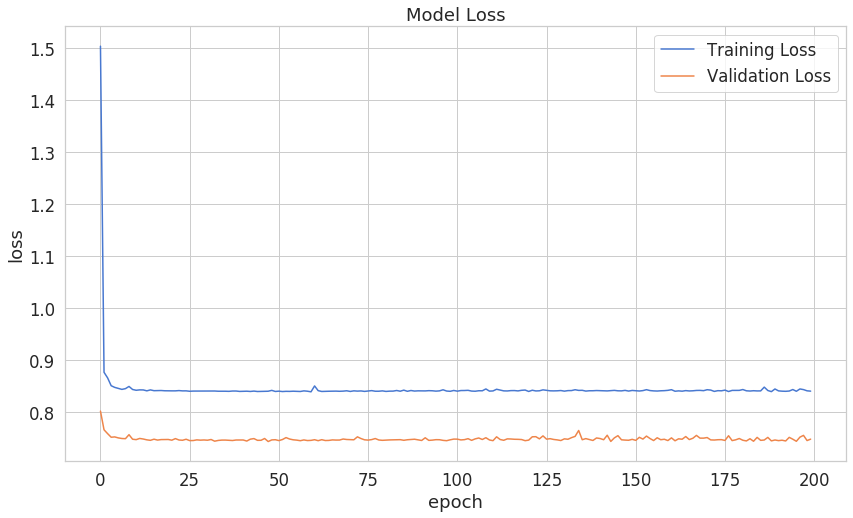

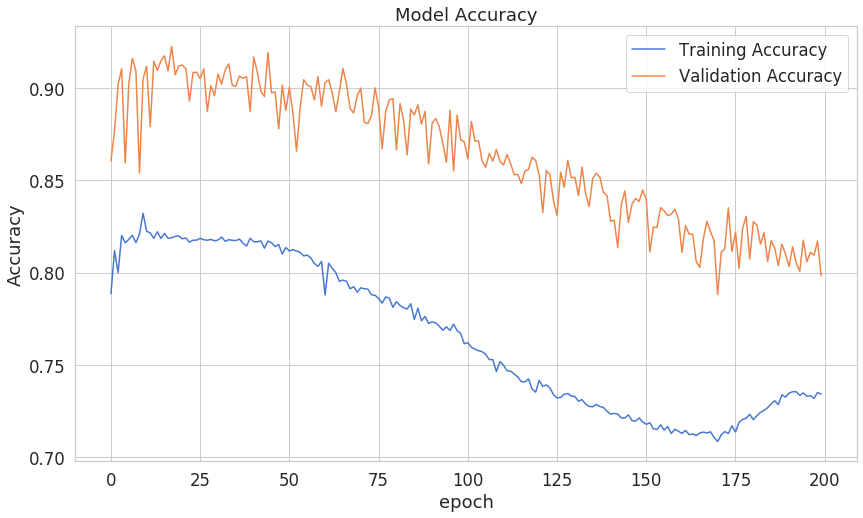

In [0]:
plot_metrics(history)

In [0]:
predictions = AutoEncoderModel.predict(X_test)

In [0]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test.ravel()})

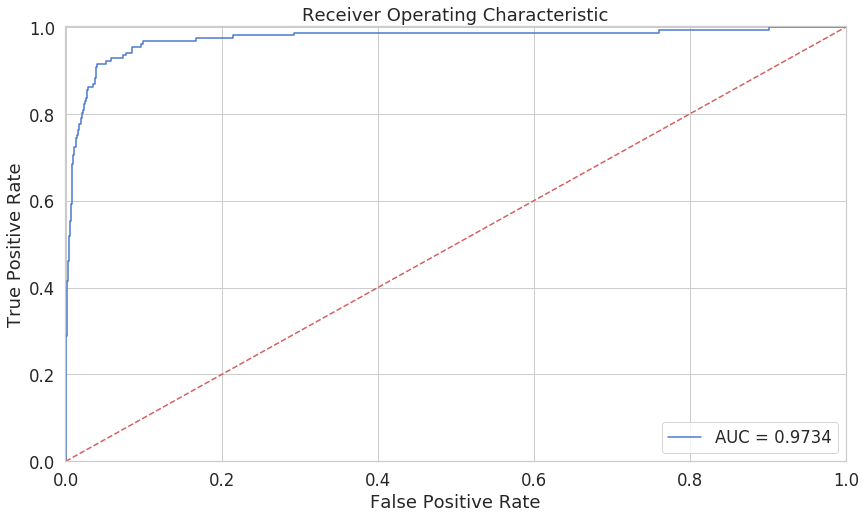

In [0]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [0]:
threshold = 2.9

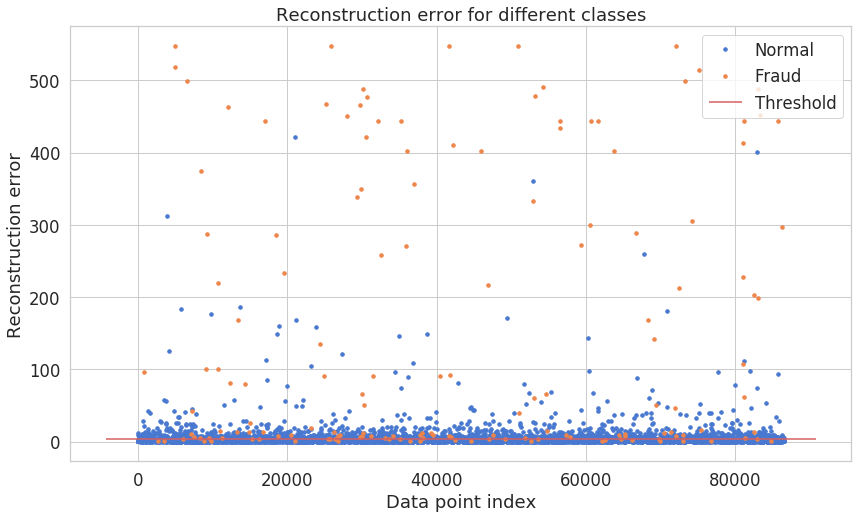

In [0]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

NameError: ignored